# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://compsci682-fa19.github.io/assignments2019/assignment1/) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [ ]:
### IF YOU ARE USING COLAB, UNCOMMENT AND RUN THIS BLOCK FIRST ###

# # Mount google drive to allow access to your files
from google.colab import drive
drive.mount('/content/drive')
drive_folder = '/content/drive/MyDrive'
# # Ajust this line to be the assignment1 folder in your google drive
notebook_folder = drive_folder + '/cs682/assignment1'
%cd {notebook_folder}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/cs682/assignment1


In [ ]:
from __future__ import print_function
import random
import numpy as np
from cs682.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs682/datasets/cifar-10-batches-py'
    # Don't forget to run get_datasets.sh, or this will throw an error
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Clear previously loaded data.
Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs682/classifiers/softmax.py**.


In [ ]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs682/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs682.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.371584
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *We want our model to consider all classes equally likely, so it should assign a probability of around 0.1 (1 divided by 10 as 10 classes) to each class. The loss is defined as the negative logarithm of the predicted probability for the correct class, so If the loss is close to -log(0.1), it means the model is doing a good job.*


In [ ]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs682.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.774000 analytic: 0.774000, relative error: 1.611029e-08
numerical: 1.124345 analytic: 1.124345, relative error: 6.895133e-08
numerical: -0.678047 analytic: -0.678047, relative error: 9.947294e-10
numerical: 1.916338 analytic: 1.916338, relative error: 1.215817e-08
numerical: 2.585404 analytic: 2.585404, relative error: 1.572906e-08
numerical: -3.852587 analytic: -3.852587, relative error: 1.250018e-10
numerical: -0.530880 analytic: -0.530880, relative error: 2.810376e-08
numerical: -1.122465 analytic: -1.122465, relative error: 8.490082e-10
numerical: 1.520448 analytic: 1.520448, relative error: 4.590045e-08
numerical: 3.704813 analytic: 3.704813, relative error: 1.184403e-08
numerical: 2.990070 analytic: 2.990069, relative error: 3.346286e-08
numerical: 0.389390 analytic: 0.389390, relative error: 4.427789e-09
numerical: -0.867165 analytic: -0.867165, relative error: 1.153740e-08
numerical: -1.270649 analytic: -1.270649, relative error: 1.027188e-08
numerical: 0.924324 an

In [ ]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs682.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.371584e+00 computed in 0.117746s
vectorized loss: 2.371584e+00 computed in 0.012618s
Loss difference: 0.000000
Gradient difference: 0.000000


In [ ]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs682.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [1e3,2.5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
l_step_size = (learning_rates[1] - learning_rates[0]) / (5 - 1)
r_step_size = (regularization_strengths[1] - regularization_strengths[0]) / (5 - 1)
for l in list(np.arange(learning_rates[0],learning_rates[1],l_step_size)):
  for r in list(np.arange(regularization_strengths[0],regularization_strengths[1],r_step_size)):
    softmax = Softmax()
    loss_hist = softmax.train(X_train, y_train, learning_rate=l, reg=r, num_iters=1500, verbose=False)
    y_train_pred = softmax.predict(X_train)
    y_val_pred = softmax.predict(X_val)
    training_accuracy = np.mean(y_train == y_train_pred)
    validation_accuracy = np.mean(y_val == y_val_pred)
    results[(l, r)] = (training_accuracy, validation_accuracy)
    if validation_accuracy > best_val:
      best_val = validation_accuracy
      best_softmax = softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 1.000000e+03 train accuracy: 0.266531 val accuracy: 0.287000
lr 1.000000e-07 reg 7.000000e+03 train accuracy: 0.349102 val accuracy: 0.352000
lr 1.000000e-07 reg 1.300000e+04 train accuracy: 0.347143 val accuracy: 0.363000
lr 1.000000e-07 reg 1.900000e+04 train accuracy: 0.336429 val accuracy: 0.349000
lr 2.000000e-07 reg 1.000000e+03 train accuracy: 0.318347 val accuracy: 0.312000
lr 2.000000e-07 reg 7.000000e+03 train accuracy: 0.363429 val accuracy: 0.377000
lr 2.000000e-07 reg 1.300000e+04 train accuracy: 0.349612 val accuracy: 0.364000
lr 2.000000e-07 reg 1.900000e+04 train accuracy: 0.333816 val accuracy: 0.357000
lr 3.000000e-07 reg 1.000000e+03 train accuracy: 0.349673 val accuracy: 0.351000
lr 3.000000e-07 reg 7.000000e+03 train accuracy: 0.365429 val accuracy: 0.385000
lr 3.000000e-07 reg 1.300000e+04 train accuracy: 0.349755 val accuracy: 0.366000
lr 3.000000e-07 reg 1.900000e+04 train accuracy: 0.333408 val accuracy: 0.341000
lr 4.000000e-07 reg 1.000000

In [ ]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.367000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*: True

*Your explanation*:
Adding a new data point to a training set can potentially leave the SVM loss unchanged if the point is correctly classified and doesn't impact the margin. In contrast, the Softmax classifier loss is more sensitive to changes when new data points are added, as it relies on class probabilities assigned to each data point. Even correctly classified points can alter these probabilities, making the loss subject to change. This sensitivity in Softmax arises from potential numerical instability, where extremely large scores can lead to exponential values, causing significant variations in loss when new data is introduced.

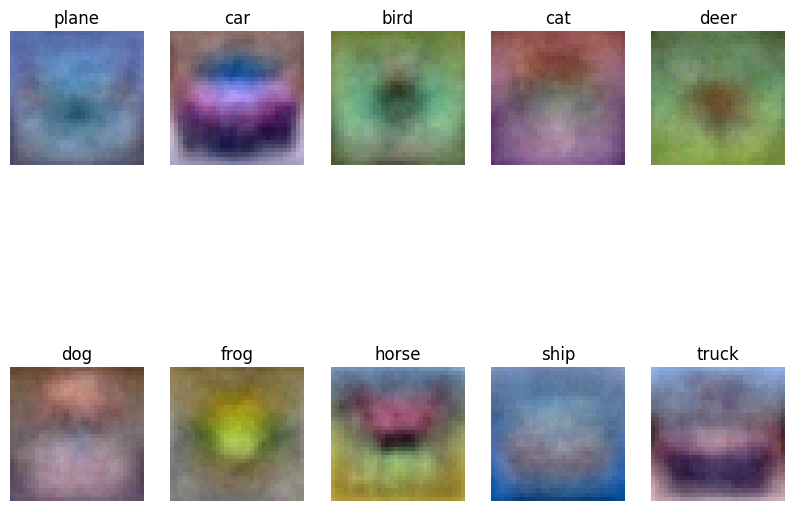

In [ ]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

# **Decision Boundaries with PCA - Softmax**

/content/drive/MyDrive/cs682/assignment1/cs682/classifiers/softmax.py:75: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(softmax_probs[np.arange(num_train), y]))


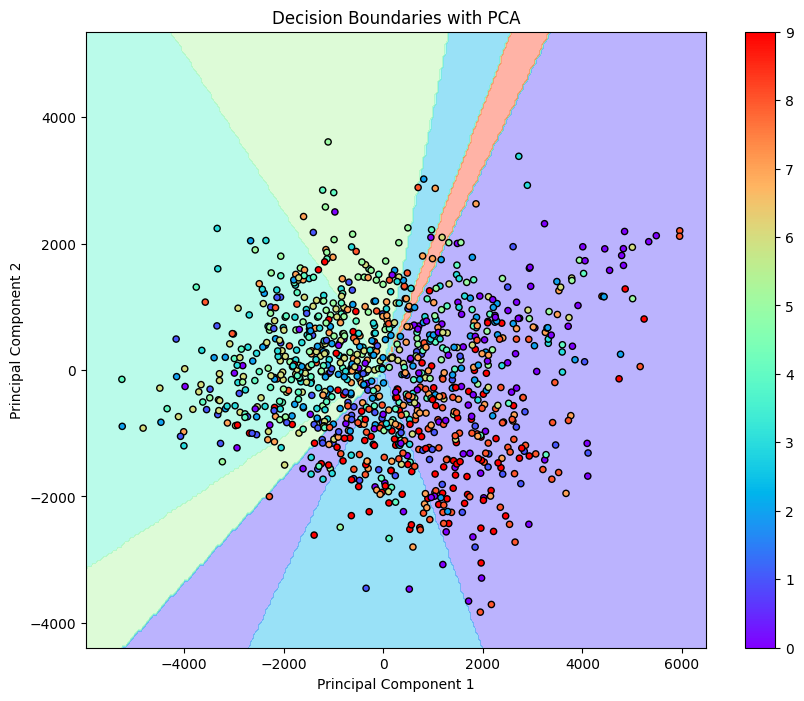

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

classifier = Softmax()
classifier.train(X_train_pca, y_train)

# Create a grid of points in 2D space
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 50),
                     np.arange(y_min, y_max, 50))

# Predict the labels for each point in the grid
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Define a colormap for 10 classes
colors = plt.cm.rainbow(np.linspace(0, 1, 10))

# Plot the decision boundaries with 10 different colors
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.rainbow)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, s=20, edgecolor='k', cmap=plt.cm.rainbow)
plt.title('Decision Boundaries with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add a colorbar for class labels
colorbar = plt.colorbar()
colorbar.set_ticks(np.arange(0, 10))
colorbar.set_ticklabels(np.arange(0, 10))

plt.show()

/content/drive/MyDrive/cs682/assignment1/cs682/classifiers/softmax.py:75: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(softmax_probs[np.arange(num_train), y]))


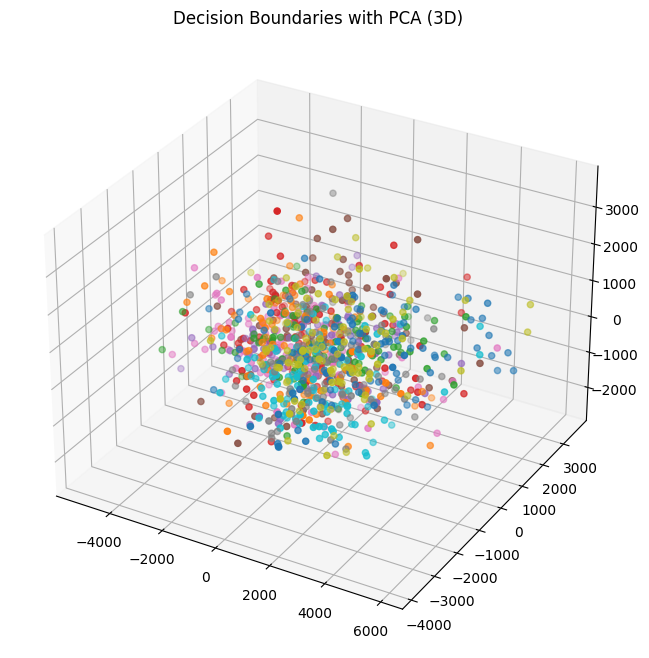

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# PCA to reduce dimensionality to 3D
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

classifier = Softmax()
classifier.train(X_train_pca, y_train)

# Create a grid of points in 3D space
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
z_min, z_max = X_train_pca[:, 2].min() - 1, X_train_pca[:, 2].max() + 1
xx, yy, zz = np.meshgrid(np.arange(x_min, x_max, 500),
                         np.arange(y_min, y_max, 500),
                         np.arange(z_min, z_max, 500))

# Predict the labels for each point in the 3D grid
points_3d = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
Z = classifier.predict(points_3d)
Z = Z.reshape(xx.shape)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for label in np.unique(y_test):
    mask = (y_test == label)
    ax.scatter(X_test_pca[mask, 0], X_test_pca[mask, 1], X_test_pca[mask, 2], label=f'Class {label}', s=20)

ax.set_title('Decision Boundaries with PCA (3D)')

classes = np.unique(y_test)
colorbar.set_ticklabels(classes)

plt.show()